In [1]:
from Models import Get_data as Gd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from Models.CAE import Encoder, Decoder, Autoencoder
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from tqdm import tqdm
import random
import scipy

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(66)  # 你可以选择任意一个数字作为种子
# 启用浮点数异常检测
# torch.autograd.set_detect_anomaly(True)

In [3]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [4]:
directory = '/home/wl4023/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

# CAE

## Create Dataset for CAE

### Use all the case

In [5]:
sparse_graph = scipy.sparse.load_npz('/home/wl4023/data/Sibo_22Mar2024/sparse_matrix_fixed.npz')
graph = scipy.sparse.csr_matrix(sparse_graph)
perm = scipy.sparse.csgraph.reverse_cuthill_mckee(graph)
print(perm)

[97148 97146 97132 ...     3     1     0]


In [6]:
dataset, length = Gd.get_all_nodes(folders[:-1])
dataset = dataset[:, perm, :]


In [7]:
train_np, val_np = train_test_split(dataset, test_size=0.2, shuffle=True)
train_np = np.expand_dims(train_np[:, :, 0], axis=2)
val_np = np.expand_dims(val_np[:, :, 0], axis=2)

In [8]:
train_tensor = torch.tensor(train_np, dtype=torch.float).permute(0, 2, 1)
train_tensor_set = Gd.MyDataset(train_tensor)

In [9]:
val_tensor = torch.tensor(val_np, dtype=torch.float).permute(0, 2, 1)
val_tensor_set = Gd.MyDataset(val_tensor)

In [10]:
train_loader = DataLoader(train_tensor_set, batch_size=5, shuffle=True)
val_loader = DataLoader(val_tensor_set, batch_size=5, shuffle=True)

In [11]:
preprocessor = Gd.Preprocessor()
preprocessor.fit(torch.concat((train_tensor, val_tensor), axis=0))
preprocessor.mean

tensor(6.9571)

### Test set

In [31]:
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = test_np[:, perm, :]
test_np = np.expand_dims(test_np[:, :, 0], axis=2)

In [32]:
print(folders[-1:])

['/home/wl4023/data/Sibo_22Mar2024/case_23/hessian_']


In [33]:
test_tensor = torch.tensor(test_np, dtype=torch.float).permute(0, 2, 1)
test_tensor_set = Gd.MyDataset(test_tensor)

## Model Info

In [15]:
latent_space = 25

In [16]:
# Create an instance of the model
encoder = Encoder(1, latent_space)
summary(encoder, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [10, 25]                  --
├─Conv1d: 1-1                            [10, 4, 97149]            36
├─Dropout: 1-2                           [10, 4, 97149]            --
├─MaxPool1d: 1-3                         [10, 4, 19429]            --
├─Conv1d: 1-4                            [10, 4, 19429]            132
├─Dropout: 1-5                           [10, 4, 19429]            --
├─MaxPool1d: 1-6                         [10, 4, 3885]             --
├─Conv1d: 1-7                            [10, 1, 3885]             33
├─LeakyReLU: 1-8                         [10, 1, 3885]             --
├─Dropout: 1-9                           [10, 1, 3885]             --
├─MaxPool1d: 1-10                        [10, 1, 777]              --
├─AdaptiveAvgPool1d: 1-11                [10, 1, 1000]             --
├─Flatten: 1-12                          [10, 1000]                --
├─Linear: 1-13

In [17]:
decoder = Decoder(latent_space, 1)
summary(decoder, input_size=(10, latent_space))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [10, 1, 97149]            --
├─Linear: 1-1                            [10, 512]                 13,312
├─Upsample: 1-2                          [10, 1, 1024]             --
├─Conv1d: 1-3                            [10, 1, 1018]             9
├─Linear: 1-4                            [10, 1, 97149]            98,994,831
├─Conv1d: 1-5                            [10, 1, 97149]            2
├─LeakyReLU: 1-6                         [10, 1, 97149]            --
Total params: 99,008,154
Trainable params: 99,008,154
Non-trainable params: 0
Total mult-adds (M): 992.12
Input size (MB): 0.00
Forward/backward pass size (MB): 15.67
Params size (MB): 396.03
Estimated Total Size (MB): 411.70

In [18]:
model = Autoencoder(1, latent_space)
summary(model, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [10, 1, 97149]            --
├─Encoder: 1-1                           [10, 25]                  --
│    └─Conv1d: 2-1                       [10, 4, 97149]            36
│    └─Dropout: 2-2                      [10, 4, 97149]            --
│    └─MaxPool1d: 2-3                    [10, 4, 19429]            --
│    └─Conv1d: 2-4                       [10, 4, 19429]            132
│    └─Dropout: 2-5                      [10, 4, 19429]            --
│    └─MaxPool1d: 2-6                    [10, 4, 3885]             --
│    └─Conv1d: 2-7                       [10, 1, 3885]             33
│    └─LeakyReLU: 2-8                    [10, 1, 3885]             --
│    └─Dropout: 2-9                      [10, 1, 3885]             --
│    └─MaxPool1d: 2-10                   [10, 1, 777]              --
│    └─AdaptiveAvgPool1d: 2-11           [10, 1, 1000]             --
│    └─Flatten

## Train CAE

In [19]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))
    
class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [20]:
def train(model, train_loader, val_loader, criterion, optimizer, metric_train, metric_val, device,scheduler=None, epochs=30):
    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []
    
    min_loss = 10000

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        relative_train_loss = 0
        for x in tqdm(train_loader):
            input = preprocessor.transform(x).to(device)
            x = x.to(device)
            optimizer.zero_grad()
            predict= model(input)
            loss = criterion(input, predict)
            loss.backward()
            optimizer.step()
            
            train_loss += criterion(x, preprocessor.inverse_transform(predict)).item()
            relative_train_loss += metric_train(x, preprocessor.inverse_transform(predict)).item()

        if scheduler != None:
            scheduler.step()
        # print(train_loss, relative_train_loss, len(train_loader))
        train_loss /= len(train_loader)
        relative_train_loss /= len(train_loader)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(relative_train_loss)

        model.eval()
        relative_val_loss = 0
        with torch.no_grad():
            val_loss = 0
            relative_val_loss = 0
            for x in val_loader:
                input = preprocessor.transform(x).to(device)
                x = x.to(device)
                predict= model(input)

                val_loss += criterion(x, preprocessor.inverse_transform(predict)).item()
                relative_val_loss += metric_train(x, preprocessor.inverse_transform(predict)).item()

            val_loss /= len(val_loader)
            relative_val_loss /= len(val_loader)

            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(relative_val_loss)
        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {relative_train_loss}, val Loss: {val_loss}, NRMSE_val_loss: {relative_val_loss}')
        
        if min_loss >= relative_val_loss:
            min_loss = relative_val_loss
            torch.save(model.state_dict(), 'CAE_reorder.pth')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list

In [21]:
model = Autoencoder(1, latent_space).to(device)
optimizer = optim.Adam(model.parameters())
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5)

## SCHEDULER

criterion = RMSELoss()
metric_train = NRMSE(train_tensor)
metric_val = NRMSE(val_tensor)

train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list = train(model,
                                                                                         train_loader,
                                                                                         val_loader,
                                                                                         criterion,
                                                                                         optimizer,
                                                                                         metric_train,
                                                                                         metric_val,
                                                                                         device,
                                                                                         scheduler = None,
                                                                                         epochs=50)

100%|██████████| 464/464 [00:25<00:00, 18.49it/s]


Epoch 1/50, train Loss: 5.771685720517717, NRMSE_train_loss: 0.11092837099467628, val Loss: 4.464505799885454, NRMSE_val_loss: 0.08580514933143196


100%|██████████| 464/464 [00:26<00:00, 17.68it/s]


Epoch 2/50, train Loss: 3.0156139866288365, NRMSE_train_loss: 0.05795830955471972, val Loss: 3.226926121218451, NRMSE_val_loss: 0.06201960323057298


100%|██████████| 464/464 [00:24<00:00, 19.33it/s]


Epoch 3/50, train Loss: 2.2561052332407443, NRMSE_train_loss: 0.043361002286285935, val Loss: 3.3171102024357895, NRMSE_val_loss: 0.06375288751361699


100%|██████████| 464/464 [00:23<00:00, 19.48it/s]


Epoch 4/50, train Loss: 1.828017742983226, NRMSE_train_loss: 0.03513341511053772, val Loss: 3.4270779665174156, NRMSE_val_loss: 0.06586640230219426


100%|██████████| 464/464 [00:23<00:00, 19.37it/s]


Epoch 5/50, train Loss: 1.6681716384301926, NRMSE_train_loss: 0.032061267925169445, val Loss: 3.336545351250418, NRMSE_val_loss: 0.06412641927278762


100%|██████████| 464/464 [00:24<00:00, 19.30it/s]


Epoch 6/50, train Loss: 1.5299887544122235, NRMSE_train_loss: 0.02940547499396228, val Loss: 3.216786812091696, NRMSE_val_loss: 0.06182473149664443


100%|██████████| 464/464 [00:23<00:00, 19.38it/s]


Epoch 7/50, train Loss: 1.4968947122066185, NRMSE_train_loss: 0.028769427115611475, val Loss: 2.843383820920155, NRMSE_val_loss: 0.05464814776747391


100%|██████████| 464/464 [00:23<00:00, 19.37it/s]


Epoch 8/50, train Loss: 1.3388545280643578, NRMSE_train_loss: 0.0257319886988061, val Loss: 2.8412712745625397, NRMSE_val_loss: 0.05460754600514112


100%|██████████| 464/464 [00:24<00:00, 19.24it/s]


Epoch 9/50, train Loss: 1.218671356681092, NRMSE_train_loss: 0.023422139502082277, val Loss: 3.2729933498234582, NRMSE_val_loss: 0.06290498778930512


100%|██████████| 464/464 [00:24<00:00, 19.30it/s]


Epoch 10/50, train Loss: 1.2714336321785533, NRMSE_train_loss: 0.024436199116311837, val Loss: 3.276894435800355, NRMSE_val_loss: 0.06297996465180969


100%|██████████| 464/464 [00:24<00:00, 19.20it/s]


Epoch 11/50, train Loss: 1.2119952261704823, NRMSE_train_loss: 0.02329382825851569, val Loss: 3.356274149541197, NRMSE_val_loss: 0.06450559542482269


100%|██████████| 464/464 [00:23<00:00, 19.36it/s]


Epoch 12/50, train Loss: 1.2183063722633083, NRMSE_train_loss: 0.023415124756364345, val Loss: 2.321057581182184, NRMSE_val_loss: 0.04460934785612185


100%|██████████| 464/464 [00:23<00:00, 19.42it/s]


Epoch 13/50, train Loss: 1.1669894900686781, NRMSE_train_loss: 0.0224288447603487, val Loss: 3.7520325132485093, NRMSE_val_loss: 0.07211183573536832


100%|██████████| 464/464 [00:24<00:00, 19.23it/s]


Epoch 14/50, train Loss: 1.0431266025607955, NRMSE_train_loss: 0.020048273612889623, val Loss: 3.0440781835851998, NRMSE_val_loss: 0.05850537455287473


100%|██████████| 464/464 [00:24<00:00, 19.19it/s]


Epoch 15/50, train Loss: 1.0636619529847442, NRMSE_train_loss: 0.0204429508564223, val Loss: 2.848076549069635, NRMSE_val_loss: 0.05473833942207797


100%|██████████| 464/464 [00:23<00:00, 19.65it/s]


Epoch 16/50, train Loss: 1.0525388542948098, NRMSE_train_loss: 0.020229171509934783, val Loss: 2.799955331559839, NRMSE_val_loss: 0.05381347817079774


100%|██████████| 464/464 [00:23<00:00, 19.42it/s]


Epoch 17/50, train Loss: 1.0182618337587035, NRMSE_train_loss: 0.019570387524536586, val Loss: 2.910491417194235, NRMSE_val_loss: 0.05593791616887882


100%|██████████| 464/464 [00:23<00:00, 19.50it/s]


Epoch 18/50, train Loss: 1.0631804250437638, NRMSE_train_loss: 0.020433696203640307, val Loss: 2.8298155562631013, NRMSE_val_loss: 0.05438737378552042


100%|██████████| 464/464 [00:23<00:00, 19.48it/s]


Epoch 19/50, train Loss: 1.0120151502818897, NRMSE_train_loss: 0.019450329974743313, val Loss: 2.9497007902326255, NRMSE_val_loss: 0.05669149693808165


100%|██████████| 464/464 [00:23<00:00, 19.37it/s]


Epoch 20/50, train Loss: 0.9685353331010917, NRMSE_train_loss: 0.01861467376423614, val Loss: 2.775956473473845, NRMSE_val_loss: 0.05335223462817998


100%|██████████| 464/464 [00:23<00:00, 19.43it/s]


Epoch 21/50, train Loss: 0.9389366395771503, NRMSE_train_loss: 0.018045804452287546, val Loss: 3.3593859847249656, NRMSE_val_loss: 0.06456540301763292


100%|██████████| 464/464 [00:23<00:00, 19.58it/s]


Epoch 22/50, train Loss: 0.9388575596927569, NRMSE_train_loss: 0.018044284565960345, val Loss: 3.5328979368867546, NRMSE_val_loss: 0.06790019952338831


100%|██████████| 464/464 [00:23<00:00, 19.56it/s]


Epoch 23/50, train Loss: 0.971172322487009, NRMSE_train_loss: 0.01866535515251473, val Loss: 3.3245472132131972, NRMSE_val_loss: 0.06389582264718824


100%|██████████| 464/464 [00:23<00:00, 19.61it/s]


Epoch 24/50, train Loss: 0.9519527767110487, NRMSE_train_loss: 0.01829596686855376, val Loss: 3.3632613112186562, NRMSE_val_loss: 0.06463988420778308


100%|██████████| 464/464 [00:23<00:00, 19.53it/s]


Epoch 25/50, train Loss: 0.8976474991389389, NRMSE_train_loss: 0.01725225171459646, val Loss: 2.7645891390997788, NRMSE_val_loss: 0.05313376093219067


100%|██████████| 464/464 [00:23<00:00, 19.63it/s]


Epoch 26/50, train Loss: 0.8882835529873083, NRMSE_train_loss: 0.017072282225728548, val Loss: 2.936361210099582, NRMSE_val_loss: 0.0564351181724462


100%|██████████| 464/464 [00:23<00:00, 19.60it/s]


Epoch 27/50, train Loss: 0.8766739681234648, NRMSE_train_loss: 0.016849152847185155, val Loss: 2.4696803524576385, NRMSE_val_loss: 0.04746578914787749


100%|██████████| 464/464 [00:23<00:00, 19.76it/s]


Epoch 28/50, train Loss: 0.8854233125417397, NRMSE_train_loss: 0.017017310084815232, val Loss: 2.874367069581459, NRMSE_val_loss: 0.05524362745726931


100%|██████████| 464/464 [00:23<00:00, 19.97it/s]


Epoch 29/50, train Loss: 0.8912440560886572, NRMSE_train_loss: 0.01712918131820986, val Loss: 2.783840919876921, NRMSE_val_loss: 0.05350376882365551


100%|██████████| 464/464 [00:23<00:00, 19.49it/s]


Epoch 30/50, train Loss: 0.8313853275673143, NRMSE_train_loss: 0.015978732056000495, val Loss: 2.9861031467544623, NRMSE_val_loss: 0.057391128711530875


100%|██████████| 464/464 [00:23<00:00, 19.48it/s]


Epoch 31/50, train Loss: 0.8158360186578899, NRMSE_train_loss: 0.015679883611075387, val Loss: 2.8133834518235306, NRMSE_val_loss: 0.054071558302204156


100%|██████████| 464/464 [00:23<00:00, 19.54it/s]


Epoch 32/50, train Loss: 0.8602510770333225, NRMSE_train_loss: 0.01653351466440403, val Loss: 3.015878453850746, NRMSE_val_loss: 0.05796339227978525


100%|██████████| 464/464 [00:23<00:00, 19.69it/s]


Epoch 33/50, train Loss: 0.7854812468305744, NRMSE_train_loss: 0.015096482936220628, val Loss: 3.1802664471083673, NRMSE_val_loss: 0.061122831727924015


100%|██████████| 464/464 [00:23<00:00, 19.59it/s]


Epoch 34/50, train Loss: 0.8095878108950525, NRMSE_train_loss: 0.015559796777810773, val Loss: 2.968887283884246, NRMSE_val_loss: 0.057060249872377206


100%|██████████| 464/464 [00:23<00:00, 19.59it/s]


Epoch 35/50, train Loss: 0.7728437042698778, NRMSE_train_loss: 0.014853596849896913, val Loss: 3.034995309237776, NRMSE_val_loss: 0.0583308068874838


100%|██████████| 464/464 [00:23<00:00, 19.48it/s]


Epoch 36/50, train Loss: 0.8645975259614402, NRMSE_train_loss: 0.016617050846027017, val Loss: 3.04059170905886, NRMSE_val_loss: 0.05843836623083415


100%|██████████| 464/464 [00:23<00:00, 19.50it/s]


Epoch 37/50, train Loss: 0.7530415251465707, NRMSE_train_loss: 0.014473010785877705, val Loss: 3.314674774120594, NRMSE_val_loss: 0.0637060802686831


100%|██████████| 464/464 [00:23<00:00, 19.55it/s]


Epoch 38/50, train Loss: 0.8376814328005602, NRMSE_train_loss: 0.01609973951367308, val Loss: 2.999860007187416, NRMSE_val_loss: 0.057655527176142765


100%|██████████| 464/464 [00:23<00:00, 19.42it/s]


Epoch 39/50, train Loss: 0.7896385340598123, NRMSE_train_loss: 0.015176383535586426, val Loss: 2.8559299265516214, NRMSE_val_loss: 0.05488927662372589


100%|██████████| 464/464 [00:23<00:00, 19.53it/s]


Epoch 40/50, train Loss: 0.7178670146085065, NRMSE_train_loss: 0.013796977577369725, val Loss: 2.833384416226683, NRMSE_val_loss: 0.05445596501873485


100%|██████████| 464/464 [00:23<00:00, 19.84it/s]


Epoch 41/50, train Loss: 0.7333277844149491, NRMSE_train_loss: 0.014094124364481982, val Loss: 3.064832710500421, NRMSE_val_loss: 0.058904264041961266


100%|██████████| 464/464 [00:23<00:00, 19.46it/s]


Epoch 42/50, train Loss: 0.8146101130365297, NRMSE_train_loss: 0.01565632247466369, val Loss: 2.8524448717462607, NRMSE_val_loss: 0.054822296016560544


100%|██████████| 464/464 [00:23<00:00, 19.98it/s]


Epoch 43/50, train Loss: 0.7406653282714302, NRMSE_train_loss: 0.014235147608219293, val Loss: 2.474143560590415, NRMSE_val_loss: 0.04755156943253402


100%|██████████| 464/464 [00:23<00:00, 19.40it/s]


Epoch 44/50, train Loss: 0.7459447674196342, NRMSE_train_loss: 0.014336615310106748, val Loss: 2.8127786702123183, NRMSE_val_loss: 0.054059935139556384


100%|██████████| 464/464 [00:23<00:00, 19.91it/s]


Epoch 45/50, train Loss: 0.7240865721270956, NRMSE_train_loss: 0.013916513758133454, val Loss: 2.9125527975888086, NRMSE_val_loss: 0.055977534422458244


100%|██████████| 464/464 [00:23<00:00, 19.52it/s]


Epoch 46/50, train Loss: 0.721537052428928, NRMSE_train_loss: 0.013867513535560334, val Loss: 2.8006970371151794, NRMSE_val_loss: 0.05382773325104138


100%|██████████| 464/464 [00:23<00:00, 19.58it/s]


Epoch 47/50, train Loss: 0.7312798216168223, NRMSE_train_loss: 0.014054763737006178, val Loss: 2.604707068410413, NRMSE_val_loss: 0.050060922613142635


100%|██████████| 464/464 [00:23<00:00, 19.45it/s]


Epoch 48/50, train Loss: 0.7201427019618708, NRMSE_train_loss: 0.013840714935213327, val Loss: 2.865673232695152, NRMSE_val_loss: 0.0550765371801139


100%|██████████| 464/464 [00:23<00:00, 19.59it/s]


Epoch 49/50, train Loss: 0.7953745743966308, NRMSE_train_loss: 0.01528662683117075, val Loss: 2.753631107766053, NRMSE_val_loss: 0.05292315398953084


100%|██████████| 464/464 [00:23<00:00, 19.45it/s]


Epoch 50/50, train Loss: 0.6977612299780394, NRMSE_train_loss: 0.01341055633383803, val Loss: 2.934321344412606, NRMSE_val_loss: 0.05639591305677233


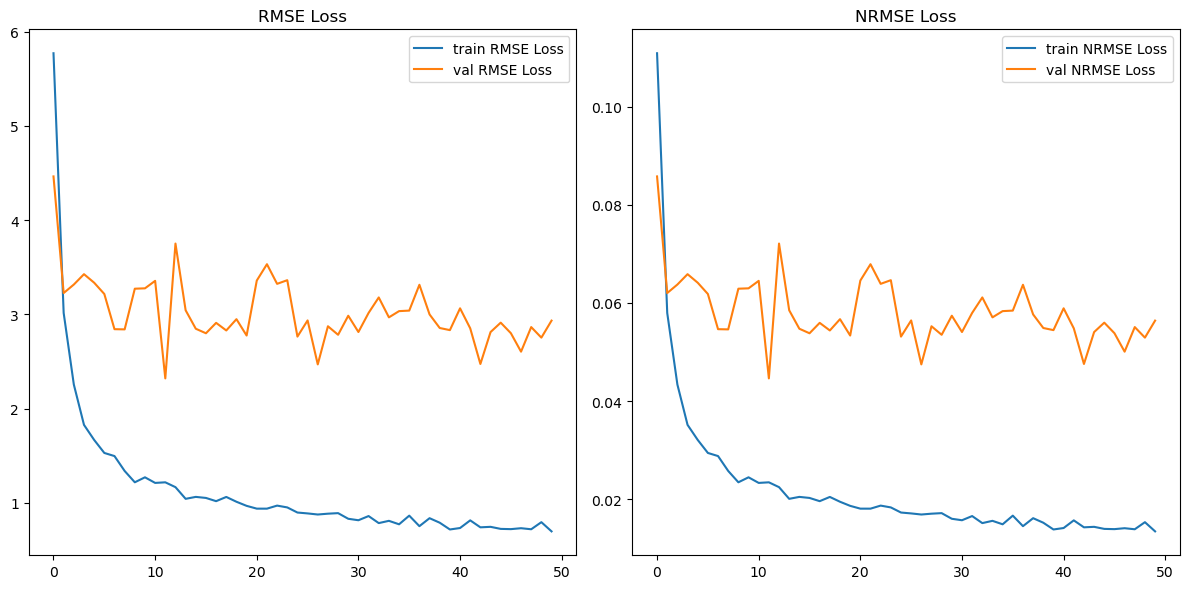

In [22]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
# plt.savefig('CAE_train_loss.png')  # 你可以更改文件名或格式
plt.show()


## Result

In [23]:
def draw_pic(x, y, coords):
    fig1, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=x[i, 0, :], cmap='bwr')
        axs[i].set_title(f'Input {i+1}')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=y[i, 0, :], cmap='bwr')
        axs[i].set_title(f'Predict {i+1}')
    plt.show()
    plt.close()


In [35]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
xycoords_check = np.load(xyfile)
xycoords_check = xycoords_check[perm, :]

In [36]:
print(xycoords_check.shape)

(97149, 2)


In [37]:
model = Autoencoder(1, latent_space)
# 加载保存的状态字典
state_dict = torch.load('CAE_reorder.pth')
model.load_state_dict(state_dict)
model.to(device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout1): Dropout(p=0.1, inplace=False)
    (pool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(4, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout2): Dropout(p=0.1, inplace=False)
    (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(4, 1, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (leaky_relu): LeakyReLU(negative_slope=0.3)
    (dropout3): Dropout(p=0.1, inplace=False)
    (pool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (avg_pool): AdaptiveAvgPool1d(output_size=1000)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=1000, out_features=25, bias=True)
  )
  (decoder): Decoder(
    (dense1): Linear(in_features=25, out_features=512, bias=True)

In [38]:
test_tensor = test_tensor.to(device)
input = preprocessor.transform(test_tensor)
y = model(input)
y = preprocessor.inverse_transform(y)
criterion = RMSELoss()
metric = NRMSE(test_tensor)

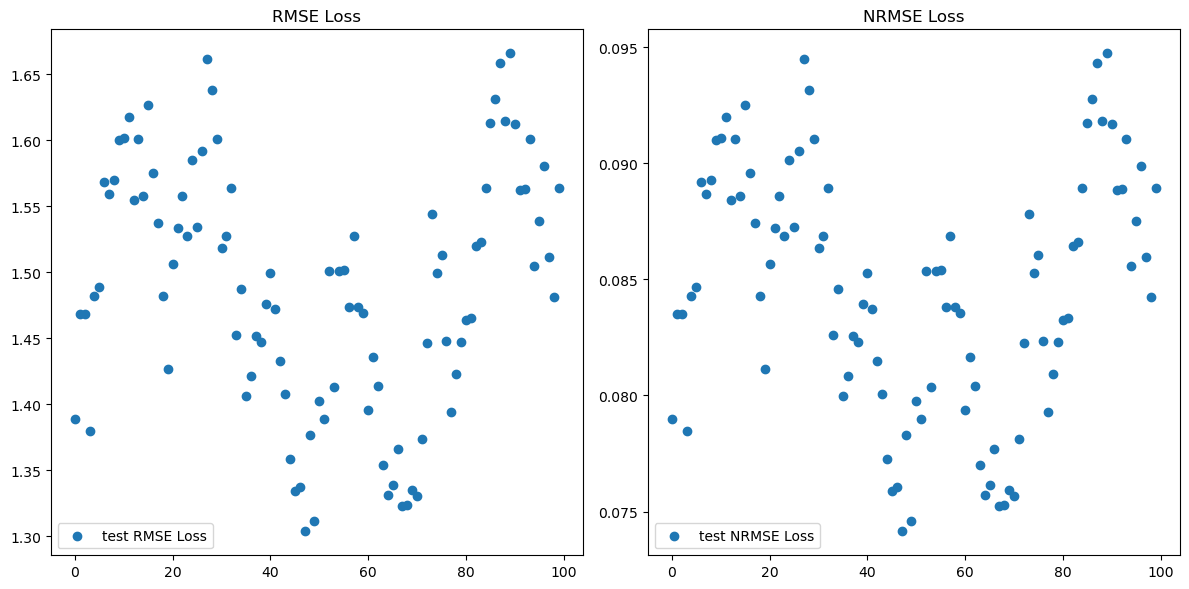

In [39]:
test_rmse=[]
test_nrmse=[]
for i in range(len(test_tensor)):
    nrmse = metric(test_tensor[i], y[i])
    rmse = criterion(test_tensor[i], y[i])

    test_rmse.append(rmse.cpu().detach().numpy())
    test_nrmse.append(nrmse.cpu().detach().numpy())


x = np.arange(0, 100)
test_rmse = np.array(test_rmse)
test_nrmse = np.array(test_nrmse)

# 保存数组到 .npy 文件
np.save('test_rmse.npy', test_rmse)
np.save('test_nrmse.npy', test_nrmse)

fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(x, test_rmse, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_nrmse, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠

# plt.savefig('CAE_test_loss.png')  # 你可以更改文件名或格式

plt.show()

In [40]:
y_np = y[:5].cpu().detach().numpy()
x_np = test_tensor[:5].cpu().detach().numpy()
rmse = criterion(test_tensor, y).item()
nrmse = metric(test_tensor, y).item()
print(f"Ave RMSE test loss: {rmse}")
print(f"Ave NRMSE test loss: {nrmse}")

Ave RMSE test loss: 1.4909948110580444
Ave NRMSE test loss: 0.08478902280330658


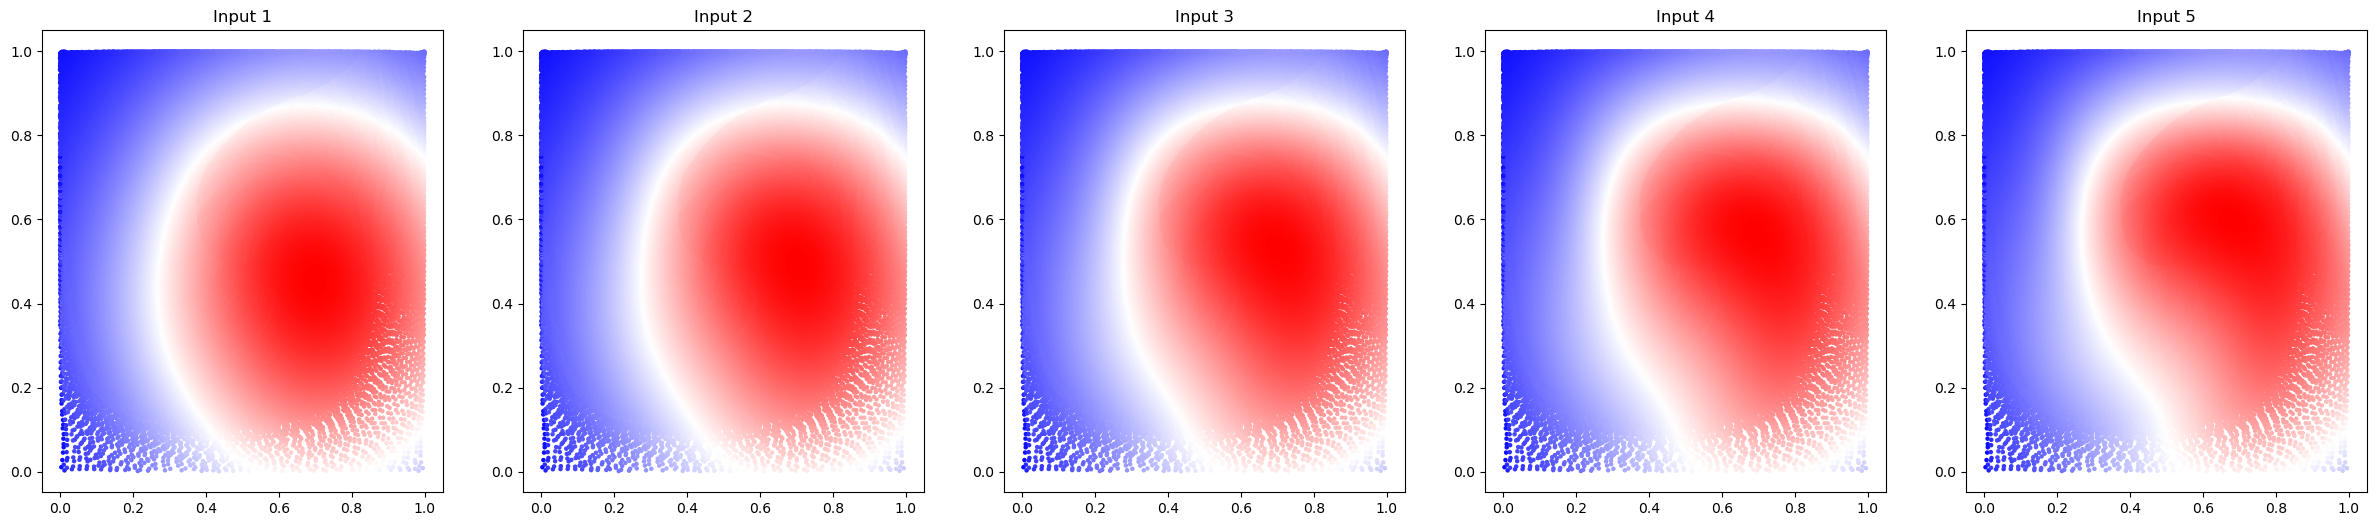

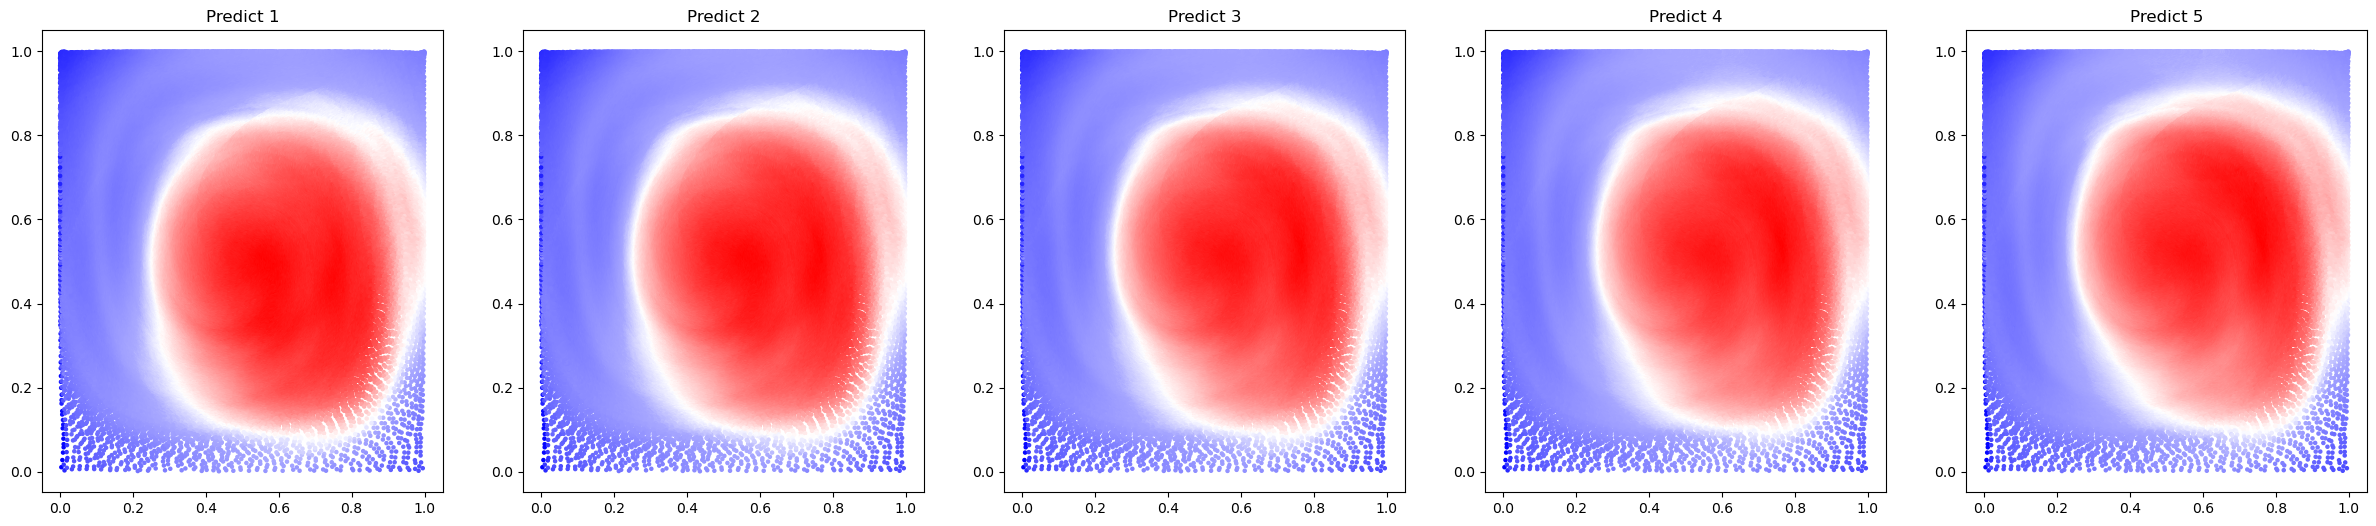

In [41]:
draw_pic(x_np, y_np, xycoords_check)